In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [13]:
import nltk
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [2]:
import pandas as pd
import numpy as np
import textwrap
import nltk
from nltk.corpus import stopwords
from nltk import word_tokenize
from nltk.stem import WordNetLemmatizer, PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer

In [3]:
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [4]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks2/NLP/lab11/bbc_text_cls (1).csv')

In [6]:
df.head()

,text,labels
0,Ad sales boost Time Warner profit\n\nQuarterly...,business
1,Dollar gains on Greenspan speech\n\nThe dollar...,business
2,Yukos unit buyer faces loan claim\n\nThe owner...,business
3,High fuel prices hit BA's profits\n\nBritish A...,business
4,Pernod takeover talk lifts Domecq\n\nShares in...,business


In [7]:
# Select a random document from the 'business' category
doc = df[df.labels == 'business']['text'].sample(random_state=42)

In [8]:
# Define a function to wrap text for better readability
def wrap(x):
  return textwrap.fill(x, replace_whitespace=False, fix_sentence_endings=True)

In [10]:
print(wrap(doc.iloc[0]))

Christmas sales worst since 1981

UK retail sales fell in December,
failing to meet expectations and making it by some counts the worst
Christmas since 1981.

Retail sales dropped by 1% on the month in
December, after a 0.6% rise in November, the Office for National
Statistics (ONS) said.  The ONS revised the annual 2004 rate of growth
down from the 5.9% estimated in November to 3.2%. A number of
retailers have already reported poor figures for December.  Clothing
retailers and non-specialist stores were the worst hit with only
internet retailers showing any significant growth, according to the
ONS.

The last time retailers endured a tougher Christmas was 23 years
previously, when sales plunged 1.7%.

The ONS echoed an earlier
caution from Bank of England governor Mervyn King not to read too much
into the poor December figures.  Some analysts put a positive gloss on
the figures, pointing out that the non-seasonally-adjusted figures
showed a performance comparable with 2003. The Novembe

In [21]:
# Split the document into sentences
sents = nltk.sent_tokenize(doc.iloc[0].split("\n", 1)[1])

In [22]:
# Create a TF-IDF vectorizer to represent sentences as numerical vectors
featurizer = TfidfVectorizer(
    stop_words=stopwords.words('english'),
    norm='l1',
)

In [23]:
# Fit the vectorizer to the sentences and transform them into a matrix
X = featurizer.fit_transform(sents)

In [24]:
# Define a function to calculate the score of a sentence based on its TF-IDF values
def get_sentence_score(tfidf_row):
  # return the average of the non-zero values
  # of the tf-idf vector representation of a sentence
  x = tfidf_row[tfidf_row != 0]
  return x.mean()

In [25]:
# Calculate the scores for each sentence
scores = np.zeros(len(sents))
for i in range(len(sents)):
  score = get_sentence_score(X[i,:])
  scores[i] = score

In [26]:
# Sort the sentences based on their scores in descending order
sort_idx = np.argsort(-scores)

In [27]:
# Many options for how to choose which sentences to include:

# 1) top N sentences
# 2) top N words or characters.
# 3) top X% sentences or top X% words
# 4) sentences with scores > average score
# 5) sentences with scores > factor * average score

# You also don't have to sort. May make more sense in order.

print("Generated summary:")
for i in sort_idx[:5]:
  print(wrap("%.2f: %s" % (scores[i], sents[i])))

Generated summary:
0.14: A number of retailers have already reported poor figures for
December.
0.13: However, reports from some High Street retailers highlight the
weakness of the sector.
0.12: The ONS revised the annual 2004 rate of growth down from the
5.9% estimated in November to 3.2%.
0.10: "Our view is the Bank of England will keep its powder dry and
wait to see the big picture."
0.10: And a British Retail Consortium survey found that Christmas 2004
was the worst for 10 years.


 # Text Summarization Using spaCy (Extractive Method)

 Extractive text summarization using the spaCy natural language processing library. It analyzes a block of input text, identifies the most important words by filtering out stopwords and punctuation, calculates sentence scores based on word frequency, and selects the top sentences to generate a concise summary.

In [37]:
# Install required packages (uncomment if running for the first time)
# !pip install -U spacy
# !python -m spacy download en_core_web_sm

import spacy
from spacy.lang.en.stop_words import STOP_WORDS
from string import punctuation
from heapq import nlargest

# Load English tokenizer, POS tagger, parser, NER, and word vectors
nlp = spacy.load('en_core_web_sm')

text = """
Climate change refers to long-term shifts in temperatures and weather patterns, mainly caused by human activities,
especially the burning of fossil fuels. This results in increased levels of greenhouse gases like carbon dioxide in
the atmosphere, leading to global warming. The effects are already visible: glaciers are melting, sea levels are
rising, and weather events like hurricanes and wildfires are becoming more frequent and intense. Governments and
organizations around the world are working on solutions such as renewable energy, conservation, and climate
agreements like the Paris Accord to mitigate the damage and adapt to these changes.
"""


# Process the text
doc = nlp(text)

# Create a list of stopwords and punctuation
stopwords = list(STOP_WORDS)
punctuation += '\n'

# Calculate word frequencies
word_frequencies = {}
for word in doc:
    if word.text.lower() not in stopwords and word.text.lower() not in punctuation:
        word_text = word.text.lower()
        word_frequencies[word_text] = word_frequencies.get(word_text, 0) + 1

# Normalize the frequencies
max_freq = max(word_frequencies.values())
for word in word_frequencies:
    word_frequencies[word] /= max_freq

# Score sentences based on word frequencies
sentence_tokens = [sent for sent in doc.sents]
sentence_scores = {}
for sent in sentence_tokens:
    for word in sent:
        word_text = word.text.lower()
        if word_text in word_frequencies:
            sentence_scores[sent] = sentence_scores.get(sent, 0) + word_frequencies[word_text]

# Get top N sentences (30% of total sentences)
select_length = int(len(sentence_tokens) * 0.3)
summary = nlargest(select_length, sentence_scores, key=sentence_scores.get)

# Convert summary sentences to string
final_summary = ' '.join([sent.text.strip() for sent in summary])
print("Summary:\n", final_summary)


Summary:
 Governments and 
organizations around the world are working on solutions such as renewable energy, conservation, and climate 
agreements like the Paris Accord to mitigate the damage and adapt to these changes.


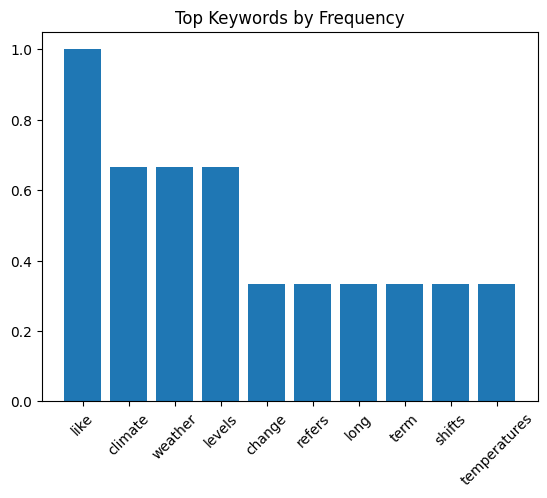

In [38]:
import matplotlib.pyplot as plt

top_words = dict(sorted(word_frequencies.items(), key=lambda x: x[1], reverse=True)[:10])
plt.bar(top_words.keys(), top_words.values())
plt.title('Top Keywords by Frequency')
plt.xticks(rotation=45)
plt.show()
